In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Statistical Signficance

In [3]:
scores

Section,Midterm
1,22
2,12
2,23
2,14
1,20
3,25
4,19
1,24
5,8
6,14


In [6]:
# average midterm score of students in section 3
np.mean(scores.where("Section", 3).column("Midterm"))

13.666666666666666

In [8]:
# average midterm score of students not in section 3
np.mean(scores.where("Section", are.not_equal_to(3)).column("Midterm"))

15.641566265060241

In [11]:
#np.max(scores.column("Midterm"))

25

What should our statsitic be here?

It should the difference between these two groups, i.e. the difference between the 2 means/averages

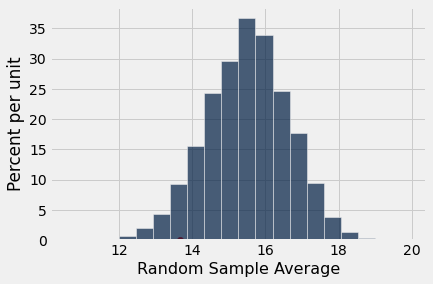

In [12]:
scores = Table.read_table('scores_by_section.csv')
scores

observed_average = 13.6667

# Simulate one value of the test statistic 
# under the hypothesis that the section is like a random sample from the class

def random_sample_midterm_avg():
    random_sample = scores.sample(27, with_replacement = False)
    return np.average(random_sample.column('Midterm'))

# Simulate 50,000 copies of the test statistic

sample_averages = make_array()

for i in np.arange(50000):
    sample_averages = np.append(sample_averages, random_sample_midterm_avg())    

# Compare the simulated distribution of the statistic
# and the actual observed statistic

averages_tbl = Table().with_column('Random Sample Average', sample_averages)
averages_tbl.hist(bins = 20)
plots.scatter(observed_average, 0, color = 'red', s=40);

In [14]:
scores.where("Section", 3).num_rows

27

In [15]:
# Simulate one value of the test statistic 
# under the hypothesis that the section is like a random sample from the class

def random_sample_midterm_avg():
    random_sample = scores.sample(27, with_replacement = False)
    return np.average(random_sample.column('Midterm'))

In [ ]:
# Simulate 50,000 copies of the test statistic

sample_averages = make_array()

for i in np.arange(50000):
    sample_averages = np.append(sample_averages, random_sample_midterm_avg())    

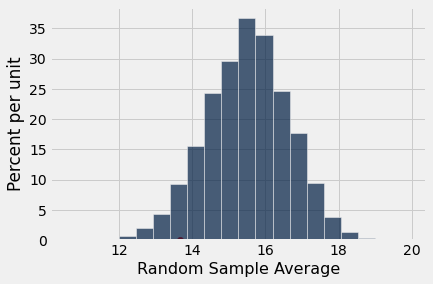

In [16]:
# Compare the simulated distribution of the statistic
# and the actual observed statistic

averages_tbl = Table().with_column('Random Sample Average', sample_averages)
averages_tbl.hist(bins = 20)
plots.scatter(observed_average, 0, color = 'red', s=40);

In [18]:
sample_averages

array([16.96296296, 16.51851852, 16.92592593, ..., 14.11111111,
       14.11111111, 14.55555556])

In [17]:
observed_average

13.6667

In [20]:
sum(sample_averages <= observed_average)

2896

In [21]:
sum(sample_averages <= observed_average) / 50000

0.05792

In [22]:
# 5% of 50,000 = 2500

five_percent_point = averages_tbl.sort(0).column(0).item(2500)
five_percent_point

13.592592592592593

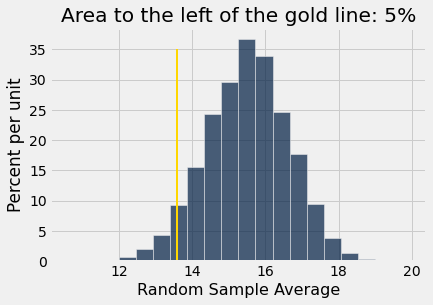

In [23]:
averages_tbl.hist(bins = 20)
plots.plot([five_percent_point, five_percent_point], [0, 0.35], color='gold', lw=2)
plots.title('Area to the left of the gold line: 5%');

# A/B Testing

In [24]:
births = Table.read_table('baby.csv')
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


Let's quickly look at the table and ask:
1. What does each row represent?
2. What do the columns represent?

**Question:** Was there an association between baby health and whether the mother was a smoker?

In [25]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


#### How many smokers and nonsmoker were there?
What table method can help us determine this?

<details>
<summary>Solution</summary>
  smoking_and_birthweight.group('Maternal Smoker')
</details>


In [26]:
smoking_and_birthweight.group("Maternal Smoker")

Maternal Smoker,count
False,715
True,459


### Distribution of birth weights for the groups
We want to look at the distribution of birth weight 
for these two groups. 

What visualization should we use?
<details>
<summary>Solution</summary>
  histogram!
</details>
<details>
<summary>Code</summary>
  smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker')
</details>


/opt/conda/lib/python3.8/site-packages/datascience/tables.py:920: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array(tuple(values))


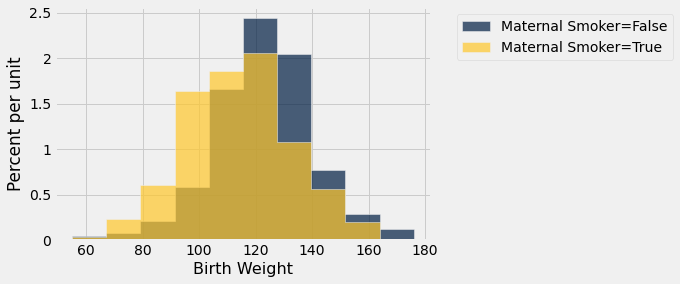

In [27]:
 smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker')

Do we see a difference between the two groups?

<details>
<summary>Solution</summary>
  Yes, the baby's whose mother's did smoke were a little lighter on average
</details>

(back to slides)
## Test Statistic

In [28]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


In [29]:
means = means_table.column(1)
observed_difference = means.item(1) - means.item(0)
observed_difference

-9.266142572024918

In [31]:
def difference_of_means(table, label, group_label):
    """Takes: name of table, column label of numerical variable,
    column label of group-label variable
    Returns: Difference of means of the two groups"""
    
    #table with the two relevant columns
    reduced = table.select(label, group_label)  
    
    # table containing group means
    means_table = reduced.group(group_label, np.average)
    # array of group means
    means = means_table.column(1)
    
    return means.item(1) - means.item(0)

In [32]:
difference_of_means(births, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

(back to slides)
# Random Permutation (Shuffling)

In [ ]:
letters = Table().with_column('Letter', make_array('a', 'b', 'c', 'd', 'e'))

In [ ]:
letters.sample()

In [ ]:
letters.sample(with_replacement = False)

In [ ]:
letters.with_column('Shuffled', letters.sample(with_replacement = False).column(0))

# Simulation Under Null Hypothesis

In [ ]:
smoking_and_birthweight

### Permute/Shuffle our data

In [ ]:
shuffled_labels = smoking_and_birthweight.sample(with_replacement=False
                                                ).column('Maternal Smoker')

In [ ]:
original_and_shuffled = smoking_and_birthweight.with_column(
    'Shuffled Label', shuffled_labels
)

In [ ]:
original_and_shuffled

In [ ]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Shuffled Label')

In [ ]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Maternal Smoker')

## Permutation Test


In [ ]:
def one_simulated_difference(table, label, group_label):
    """Takes: name of table, column label of numerical variable,
    column label of group-label variable
    Returns: Difference of means of the two groups after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = table.sample(with_replacement = False
                                                    ).column(group_label)
    
    # table of numerical variable and shuffled labels
    shuffled_table = table.select(label).with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, label, 'Shuffled Label') 

In [ ]:
one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')

In [ ]:
differences = make_array()

for i in np.arange(2500):
    new_difference = one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')
    differences = np.append(differences, new_difference)

In [ ]:
Table().with_column('Difference Between Group Means', differences).hist()
print('Observed Difference:', observed_difference)
plots.title('Prediction Under the Null Hypothesis');